In [13]:
# Number of data points to plot
num_points = 10

# Parameter ranges below
gc_actual = 0.1
gc_lo = 0.05
gc_hi = 0.5

ggap_actual = 1.0
ggap_lo = 0.5
ggap_hi = 1.5

gsyn_actual = 1.0
gsyn_lo = 0.5
gsyn_hi = 1.5

C_actual = 0.015

In [49]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

def gen_simulation_data(param_lo, param_hi, param_to_full_param_fcn, num_points):
  param_vals = []
  dom_amplitude_vals = []
  dom_amplitude_convergence_vals = []
  dom_period_vals = []
  dimensionality_vals = []

  i = 0
  for param in np.linspace(param_lo, param_hi, num_points):
    i += 1
    start_time = time.time()
    param_vec = param_to_full_param_fcn(param)
    fwd_dynamics = simulate_until_stable(
      C = param_vec['C'], Gc = param_vec['Gc'], ggap = param_vec['ggap'], gsyn = param_vec['gsyn'])
    elapsed_time = time.time() - start_time
    print("Iteration {0}/{1} took {2:.2f}s".format(i, num_points, elapsed_time))

    n = fwd_dynamics.shape[0]
    X = fwd_dynamics - fwd_dynamics.mean(axis = 0)
    pca = PCA()
    projected_X = pca.fit_transform(fwd_dynamics)
    dom_mode = projected_X[:,0]
    dom_amplitude = get_amplitude(dom_mode)
    dom_amplitude_convergence = get_amplitude_convergence(dom_mode)
    dom_period = get_period(dom_mode)
    eigen_vals = get_eigenvalues_from_pca(pca, n)
    dimensionality = get_dimensionality(eigen_vals)

    param_vals.append(param)
    dom_amplitude_vals.append(dom_amplitude)
    dom_amplitude_convergence_vals.append(dom_amplitude_convergence)
    dom_period_vals.append(dom_period)
    dimensionality_vals.append(dimensionality)
  return (param_vals, dom_amplitude_vals, dom_amplitude_convergence_vals, dom_period_vals, dimensionality_vals)

def plot_simulation_results(param_vals, dom_amplitude_vals,
                            dom_amplitude_convergence_vals, dom_period_vals, dimensionality_vals):
  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
  ax = axes[0]
  ax.scatter(param_vals, dom_amplitude_vals)
  ax.set_title("Dom amplitude")
  ax = axes[1]
  ax.scatter(param_vals, dom_amplitude_convergence_vals)
  ax.set_title("Dom amplitude convergence")
  ax = axes[2]
  ax.scatter(param_vals, dom_period_vals)
  ax.set_title("Dom period")
  ax = axes[3]
  ax.scatter(param_vals, dimensionality_vals)
  ax.set_title("Dimensionality")
  return fig

# Gc tweaks

Iteration 1/10 took 3.04s
Iteration 2/10 took 2.96s
Iteration 3/10 took 2.69s
Iteration 4/10 took 1.86s
Iteration 5/10 took 2.48s
Iteration 6/10 took 2.07s
Iteration 7/10 took 1.48s
Iteration 8/10 took 1.86s
Iteration 9/10 took 1.47s
Iteration 10/10 took 1.49s


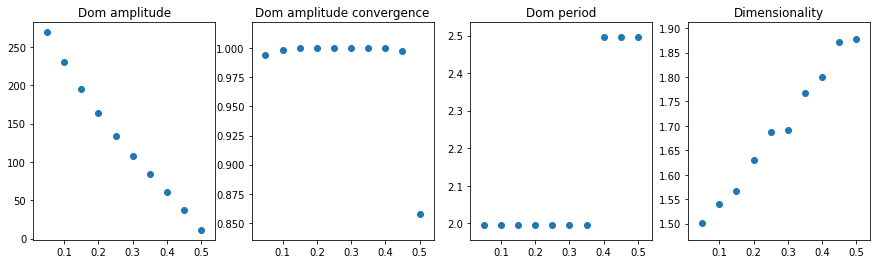

In [54]:
def gc_to_full_param(gc):
  return {
    'C': C_actual,
    'Gc': gc,
    'ggap': ggap_actual,
    'gsyn': gsyn_actual
  }

fig = plot_simulation_results(*gen_simulation_data(gc_lo, gc_hi, gc_to_full_param, 10))

# Ggap tweaks

Iteration 1/10 took 2.81s
Iteration 2/10 took 3.49s
Iteration 3/10 took 3.69s
Iteration 4/10 took 2.64s
Iteration 5/10 took 2.28s
Iteration 6/10 took 3.15s
Iteration 7/10 took 1.97s
Iteration 8/10 took 1.60s
Iteration 9/10 took 1.50s
Iteration 10/10 took 1.15s


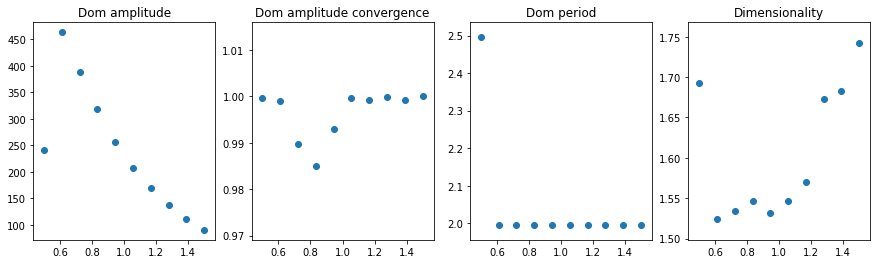

In [55]:
def ggap_to_full_param(ggap):
  return {
    'C': C_actual,
    'Gc': gc_actual,
    'ggap': ggap,
    'gsyn': gsyn_actual
  }

fig = plot_simulation_results(*gen_simulation_data(ggap_lo, ggap_hi, ggap_to_full_param, 10))

# Gsyn tweaks

Iteration 1/10 took 2.12s
Iteration 2/10 took 2.48s
Iteration 3/10 took 2.82s
Iteration 4/10 took 2.71s
Iteration 5/10 took 2.51s
Iteration 6/10 took 2.46s
Iteration 7/10 took 1.89s
Iteration 8/10 took 1.87s
Iteration 9/10 took 1.90s
Iteration 10/10 took 1.53s


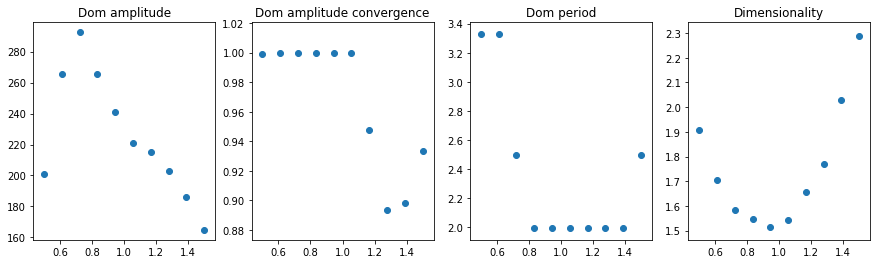

In [53]:
def gsyn_to_full_param(gsyn):
  return {
    'C': C_actual,
    'Gc': gc_actual,
    'ggap': ggap_actual,
    'gsyn': gsyn
  }

fig = plot_simulation_results(*gen_simulation_data(gsyn_lo, gsyn_hi, gsyn_to_full_param, 10))